# Import Libraries

In [47]:
# !pip install tensorflow
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
import warnings
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from random import randrange


In [2]:
# import pickle
# corr_list = []
# for i in range(1,100):
#     f_M = np.random.uniform(0,1,5)
#     G = np.random.binomial(n=2,p = f_M, size = (100,5))
# #     G = preprocessing.scale(G, axis=0)
#     G = pd.DataFrame(G)
#     corr  = G.corr()
#     corr_list.append(corr)
# with open('/Users/kevin/Downloads/Correlations_100', 'wb') as fp:
#     pickle.dump(corr_list, fp)

In [3]:
# with open ('/Users/kevin/Downloads/Correlations_100', 'rb') as fp:
#     corr2list = pickle.load(fp)

# One Loci

In [4]:
def trait_simulation_oneloci(samples_n, loci_m,var_g,var_e):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    print(SNP[0:30])
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G,samples_n,loci_m

# One Loci Binary Traits

In [5]:
def trait_simulation_oneloci_binary(samples_n, loci_m,var_g,var_e):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    #Before converting to categorical standerdize
    Y_n = preprocessing.scale(Y_n, axis=0)
    #Convert trait vector based on threshold here its point .2
    #Y_n =  np.where(Y_n > 0.2, 1, 0)
    #Alternative to threshold
    Y_sorted = sorted(Y_n)
    Ymed = np.median(Y_sorted);
    Y_n =  np.where(Y_n > Ymed, 1, 0)
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G,samples_n,loci_m

# Two Loci No Interaction Binary Traits

In [6]:
def trait_simulation_twolociBinary_nointer(samples_n, loci_m,var_g,var_e):
    f_M = np.random.uniform(0,1,loci_m)
    var_g = var_g/2
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    #two random numbers without replacement
    loci = random.sample(range(0,loci_m), 2)
    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    #doesnt matter which SNP we choose from since their both same length
    individuals = len(SNP1)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i_SNP1 = np.random.normal(0, sigma_b)
    b_i_SNP2 = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G1 and G2 will be the jth individual from our SNP1 and SNP 2 for the loci
        G1 = SNP1[k]
        G2 = SNP2[k]
        Y_j = (G1*b_i_SNP1)+(G2*b_i_SNP2) + e_j
        Y_n[k] = Y_j 
    Y_n = preprocessing.scale(Y_n, axis=0)
    #Convert trait vector based on threshold here its point .2
    #Y_n =  np.where(Y_n > 0.2, 1, 0)
    #Alternative to threshold
    Y_sorted = sorted(Y_n)
    Ymed = np.median(Y_sorted);
    Y_n =  np.where(Y_n > Ymed, 1, 0)
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G,samples_n,loci_m

# Two Loci No Interaction

In [144]:
def trait_simulation_twoloci_nointer(samples_n, loci_m,var_g,var_e):
    f_M = np.random.uniform(0,1,loci_m)
    var_g = var_g/2
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    #two random numbers without replacement
    loci = random.sample(range(0,loci_m), 2)
    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    print(SNP2[0:30])
    #doesnt matter which SNP we choose from since their both same length
    individuals = len(SNP1)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i_SNP1 = np.random.normal(0, sigma_b)
    b_i_SNP2 = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G1 and G2 will be the jth individual from our SNP1 and SNP 2 for the loci
        G1 = SNP1[k]
        G2 = SNP2[k]
        Y_j = (G1*b_i_SNP1)+(G2*b_i_SNP2) + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G,samples_n,loci_m

# Two Loci  Interaction

In [19]:
#Generate base phenotype values
def trait_simulation_twoloci_inter(samples_n,loci_m,var_g,var_e, n_causal_SNPs,b12_event,scalings = True):
    #create allele frequencies
    f_M = np.random.uniform(0,1,loci_m)
    #create G matrix bases on allele frequencies
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    #scale or not depending on input, default is True
    if scalings: 
        G = preprocessing.scale(G, axis=0)
    #rows are the loci so each person has a row of different loci
    individuals = len(G)    
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g/n_causal_SNPs)
    #b_i = loci effect on phenotype
    b_1 = np.random.normal(0, sigma_b)
    b_2 = np.random.normal(0, sigma_b)
    loci =random.sample(range(0, loci_m), 2)
    print(loci[0])
    print(loci[1])

    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    individuals = len(SNP1)    
    #rows are the loci so each person has a row of different loci
    Y_n = np.zeros((individuals, 1));
    
    #depending on b1_event b12 will be different
    # if 0 then b12 has no effect
    if (b12_event == 0):
        b_12 = 0
    #if 1 then Random Combined Effect
    elif(b12_event == 1):
        b_12 = np.random.normal(0, sigma_b)
    #if 2 then: 0 < b_12 < b1
    elif(b12_event == 2):
        b_12 = random.uniform(0, abs(b_1))
    #if 3 then: 0 < b_12 < b2
    elif(b12_event == 3):
        b_12 = random.uniform(0, abs(b_2))
    #if 4 then: b_1 + b_2 < b_12
    elif(b12_event == 4):
        b_12 = random.uniform(abs(b_1) + abs(b_2), 1)
    #if 5 then: b_12 < 0
    elif(b12_event == 5):
        b_12 = random.uniform(-1 * sigma_b, 0)
             
    #create phenotype vector
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choice
        G_ij1  = SNP1[k]
        G_ij2  = SNP2[k]
        Y_j = (b_1*G_ij1) + (b_2*G_ij2) + (b_12 * (G_ij1 * G_ij2))+ e_j 
        Y_n[k] = Y_j 
    #add Y traits to G matrix
    G = np.append(G, Y_n, axis=1)
    return G, loci_m

In [8]:
#Generate Genotype
def generate_genotype(n, m, processing = True):
    f_M = np.random.uniform(0,1,m)
    G = np.random.binomial(n=2,p = f_M, size =  (n,m))
    if processing: 
        G = preprocessing.scale(G, axis=0)
    return G

#Generate base phenotype values
def generate_base_pheno_values(G, var_g, var_e, n_causal_SNPs):
    #rows are the loci so each person has a row of different loci
    individuals = len(G)    
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g/n_causal_SNPs)
    #b_i = loci effect on phenotype
    b_1 = np.random.normal(0, sigma_b)
    b_2 = np.random.normal(0, sigma_b)
    
    loci =random.sample(range(0, len(G[0])), 2)
    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    return b_1, b_2, SNP1, SNP2, sigma_e, sigma_b

def generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, b_12):
    individuals = len(SNP1)    
    #rows are the loci so each person has a row of different loci
    Y_n = np.zeros((individuals, 1));
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
#         e_j = np.random.normal(0, sigma_e)
        e_j =0
        
        #G_ij will be the jth individual from our SNP for the loci of choice
        G_ij1  = SNP1[k]
        G_ij2  = SNP2[k]
        Y_j = (b_1*G_ij1) + (b_2*G_ij2) + (b_12 *( G_ij1 * G_ij2))+ e_j 
        Y_n[k] = Y_j 
    return Y_n

In [9]:
def shap_interact_avg(shap_values,x_test,forReg):
    shap_values = np.array(shap_values)
    avg_shap = []
    for i in range(0,len(shap_values[0])):
        shap2 = np.mean(abs(shap_values[:,i]))
        avg_shap.append(shap2)
    temp1 = np.asarray(avg_shap)     
    indices = temp1.argsort()[-4:][::-1]
    index1 = int(indices[0])
    index2 = int(indices[1])
    shap_interaction_values = shap.TreeExplainer(forReg).shap_interaction_values(x_test)
    shap_avg = np.mean(shap_interaction_values[:,index1,index2])
    return shap_avg,indices

In [10]:
def plot_ints(shap_interaction_values, indices,shap_avgL):
    loci_plots = np.zeros((len(shap_interaction_values),6))
    loci_plots[:,0] = shap_interaction_values[:,indices[0],indices[1]]
    loci_plots[:,1] = shap_interaction_values[:,indices[0],indices[2]]
    loci_plots[:,2] = shap_interaction_values[:,indices[0],indices[3]]
    loci_plots[:,3] = shap_interaction_values[:,indices[1],indices[2]]
    loci_plots[:,4] = shap_interaction_values[:,indices[1],indices[3]]
    loci_plots[:,5] = shap_interaction_values[:,indices[2],indices[3]]
    data_to_plot =loci_plots
    positions = np.arange(6) + 1
    fig, ax = plt.subplots(1,1, figsize=(9,4))
    loci_pairs = ['Loci '+str(indices[0])+'&'+str(indices[1]), 'Loci '+str(indices[0])+'&'+str(indices[2]), 
                  'Loci '+str(indices[0])+'&'+str(indices[3]), 
                  'Loci '+str(indices[1])+'&'+str(indices[2]), 
                  'Loci '+str(indices[1])+'&'+str(indices[3]),'Loci '+str(indices[2])+'&'+str(indices[3])]
    bp = ax.boxplot(data_to_plot, positions=positions,showfliers=False,whis=None,whiskerprops=None)
    means = [np.mean(data) for data in data_to_plot.T]
    ax.plot(positions, means, 'rs')
    ax.set_xticklabels(loci_pairs, fontdict=None, minor=False)
    ax.set_title("Average SHAP Interaction Between Loci, e = 0")
    ax.set_ylabel("SHAP Interaction Value")
    ax.set_xlabel("Loci Pairs")

    plt.show()

In [149]:
G = generate_genotype(1000, 50)
b_1, b_2, SNP1, SNP2, sigma_e, sigma_b = generate_base_pheno_values(G, 0.9, .2, 2)
b_1 = .5
b_2 = .5

Y_lists = []
#No Effect
b_12 = 0
Z = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, b_12)
Y_lists.append(Z)

#Random Combined Effect
# b_12 = np.random.normal(0, sigma_b)
b_12 = 2
A = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, b_12)
Y_lists.append(A)

#0 < b_12 < b1
# b_12 = random.uniform(0, abs(b_1))
b_12 = -2
B = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, b_12)
Y_lists.append(B)

#0 < b_12 < b2
# b_12 = random.uniform(0, abs(b_2))
b_12 = 4
C = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, b_12)
Y_lists.append(C)


#b_1 + b_2 < b_12
# b_12 = random.uniform(abs(b_1) + abs(b_2), 1)
b_12 = -4
D = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, b_12)
Y_lists.append(D)

#b_12 < 0
# b_12 = random.uniform(-1 * sigma_b, 0)
# E = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, b_12)
# Y_lists.append(E)


## G0 to G5 are for b12 values above

In [158]:
G0 = np.append(G, Y_lists[0], axis=1)
G1 = np.append(G, Y_lists[1], axis=1)
G2 = np.append(G, Y_lists[2], axis=1)
G3 = np.append(G, Y_lists[3], axis=1)
G4 = np.append(G, Y_lists[4], axis=1)
# G5 = np.append(G, Y_lists[5], axis=1)

## G_oneloci is for one loci

In [45]:
G_oneloci, samples_n,loci_m = trait_simulation_oneloci(500,20,.7,.3)

[ 0.32451343  0.32451343  0.32451343  0.32451343  0.32451343  0.32451343
  0.32451343  0.32451343  0.32451343  0.32451343 -1.1505476  -1.1505476
  0.32451343  1.79957446 -1.1505476  -1.1505476   0.32451343  0.32451343
 -1.1505476   1.79957446  0.32451343  0.32451343  0.32451343 -1.1505476
  0.32451343 -1.1505476  -1.1505476   0.32451343  0.32451343 -1.1505476 ]


## G_oneloci_binary is for one loci, this has binary traits

In [ ]:
G_oneloci_binary, samples_n,loci_m = trait_simulation_oneloci_binary(500,20,.7,.3)

## G_twoloci_binary is for one loci, this has binary traits

In [ ]:
G_twoloci_binary, samples_n,loci_m = trait_simulation_twolociBinary_nointer(500,20,.7,.3)

## G_twoloci is for two loci no interaction

In [11]:
G_twoloci, samples_n,loci_m = trait_simulation_twoloci_nointer(1000,40,.5,.5)

NameError: name 'trait_simulation_twoloci_nointer' is not defined

## G_twointerloci is for two loci with interaction

In [56]:
e_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
[float(m) for m in e_list]# #this is a list of list
var_e = e_list[randrange(10)]
G_twointerloci,loci_m = trait_simulation_twoloci_inter(1000,40,.5,var_e,2,0)

7
15


In [ ]:
# #individuals
# n = 500
# #loci
# m = 20


# #here every matrix entree has to be zero or one, with having a f_i probability to get selected
# #frequency of alleles, random uniform distribution between 0 and 1, with m samples
# f_M = np.random.uniform(0,1,m)

# #initialize G matrix
# # G = np.zeros((n, m));

# # #will be used to flip a coin based on f_i
# # #higher f_i frequency = higher chance of returning true
# # def loci_frequency_flip(f_i):
# #     return random.random() < f_i

# # #use this if I wanted to populate entire G matrix
# # #k are the colums(loci)
# # for k in range (0, len(G[0])):
# #     # j are the rows(individuals)
# #     for j in range (0, len(G)):
# #         #frequency of loci k we are currently on
# #         if(loci_frequency_flip(f_M[k])):
# #             G[j,k] = 1
# #creates a G matrix where each loci has a chance to be 0 or 1 based on their 
# #frequency from the uniform distribution f_m
# G = np.random.binomial(n=2,p = f_M, size =  (n,m))

# # If 0, independently standardize each feature, otherwise (if 1) standardize each sample, so choosing 0 
# # to do column wise scaling
# G = preprocessing.scale(G, axis=0)
# # choose random SNP
# loci =random.randint(0,m-1)

# #select SNP
# SNP = G[:,loci]

# #preview of the data
# print(SNP[0:30])

# F_i distribution plot

In [ ]:
# #use this to see distribution of f_i frequency
# bin_size = 20
# count, bins, ignored = plt.hist(f_M, 20, facecolor='blue') 

# plt.xlabel('X [0,1]')
# plt.ylabel('Count')
# plt.title("Uniform Distribution For Loci Frequency Bin size: "+str(bin_size))
# plt.axis([0, 1, 0, len(f_M]) # x_start, x_end, y_start, y_end
# plt.grid(True)

# plt.show(block = False)

# Split the data

In [57]:
#split data into test and train
X = G_twointerloci[:,0:len(G_twointerloci[0])-2]

#last column is the appended Y vector we predicted
y = G_twointerloci[:,len(G_twointerloci[0])-1]

#split the data, 70% training
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [50]:
#training the algorithm
linReg = LinearRegression() 
linReg.fit(x_train, y_train) 

LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
#test the model on test data
y_predict = linReg.predict(x_test)

# Linear Regression Evaluation

In [ ]:
#Evaluate the regression model
print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2))
print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
rmse = metrics.mean_squared_error(y_test, y_predict)
print("Root Mean squared error =", round(sqrt(rmse),2))
print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))

# Prediction Error

In [ ]:
#prediction error plot
diff = y_test - y_predict
plt.hist(diff,bins = 30, color = 'blue')
plt.title('Prediction Errors')
plt.xlabel('Phenotype prediction error')
plt.ylabel('Frequency')

In [ ]:
x_vals = []
for i in range(0,19):
    x_vals.append(x_train[i].mean())

In [ ]:
import operator
index, value = max(enumerate(x_vals), key=operator.itemgetter(1))

In [ ]:
print(linReg.coef_)

In [ ]:
print(np.std(x_train, 0)*linReg.coef_)

# Extract SHAP values

In [ ]:
warnings.filterwarnings("ignore")
explainer = shap.KernelExplainer(linReg.predict, shap.sample(x_train,100))
shap_values = explainer.shap_values(x_test)

In [ ]:
shap.summary_plot(shap_values, x_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values,x_test)

# Random Forest Regressor

In [58]:
#Random Forest Regression
#initialize tree with a node depth of 10 and 50 decision trees
forReg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=50)
forReg.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=0)

# RFR Evaluation

In [59]:
y_predict2 = forReg.predict(x_test)
#Evaluate the regression model
print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict2), 2))
print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict2), 2)) 
rmse = metrics.mean_squared_error(y_test, y_predict2)
print("Root Mean squared error =", round(sqrt(rmse),2))
print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict2), 2)) 
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict2), 2)) 
print("R2 score =", round(metrics.r2_score(y_test, y_predict2), 2))

Mean absolute error = 0.0
Mean squared error = 0.0
Root Mean squared error = 0.0
Median absolute error = 0.0
Explain variance score = 1.0
R2 score = 1.0


# RFR Prediction Error

Text(0, 0.5, 'Frequency')

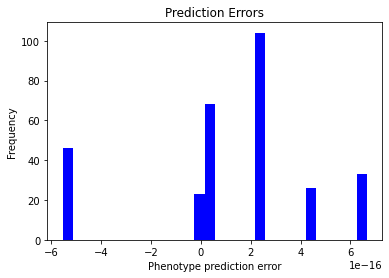

In [60]:
diff = y_test - y_predict2
plt.hist(diff,bins = 30, color = 'blue')
plt.title('Prediction Errors')
plt.xlabel('Phenotype prediction error')
plt.ylabel('Frequency')

# RFR SHAP Values and Plots

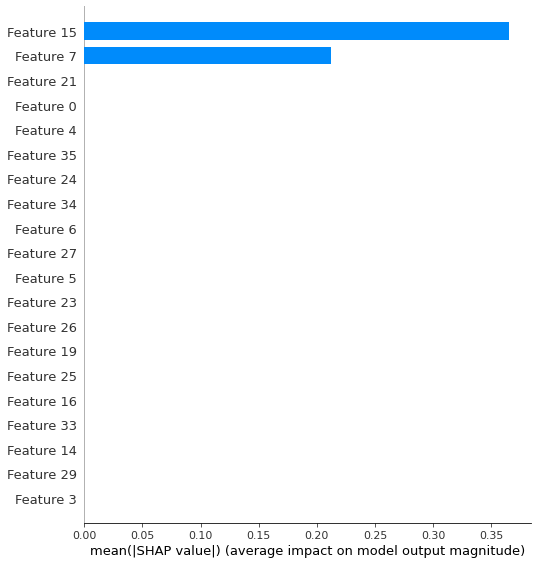

In [61]:
warnings.filterwarnings("ignore")
shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
# shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
shap.summary_plot(shap_values, x_test, plot_type="bar")

In [196]:
shap_values.shape

(700, 49)

In [165]:
# def mean_shap_values(shap_values):
#     if len(shap_values) == 2:
#         mean_shap = [0] * len(shap_values[0][0])
#         for shap_value in shap_values[0]:
#             for x in range(0, len(shap_value)):
#                 mean_shap[x] = mean_shap[x] + abs(shap_value[x])
#         for x in range(0, len(shap_values[0])):
#             mean_shap[x] = abs(mean_shap[x] / len(shap_values[0]))
#     else:    
#         mean_shap = [0] * len(shap_values[0])
#         for shap_value in shap_values:
#             for x in range(0, len(shap_value)):
#                 mean_shap[x] = mean_shap[x] + abs(shap_value[x])
#         for x in range(0, len(shap_values[0])):
#             mean_shap[x] = abs(mean_shap[x] / len(shap_values[0]))
#     return mean_shap                   

# def max_mean_feature(shap_values):
#     mean_shap = mean_shap_values(shap_values)
#     return mean_shap.index(max(mean_shap)), mean_shap[mean_shap.index(max(mean_shap))]

In [166]:
# index, shap = max_mean_feature(shap_values)
# shap

In [190]:
avg_shap = []
for i in range(0,len(shap_values[0])):
    shap2 = np.mean(abs(shap_values[:,i]))
    avg_shap.append(shap2)
temp1 = np.asarray(avg_shap)     
indices = temp1.argsort()[-1:][::-1]
# loci1,loci2 = avg_shap[indices[0]],avg_shap[indices[1]]
int(indices[0])

33

In [ ]:
shap.summary_plot(shap_values,x_test)

# SHAP Interaction Value

In [ ]:
shap.initjs()
shap_interaction_values = shap.TreeExplainer(forReg).shap_interaction_values(x_test)

In [ ]:
len(shap_interaction_values)

In [ ]:
# shap.summary_plot(shap_interaction_values, features=x_test, max_display=4)

In [ ]:
shap_avg,indices = shap_interact_avg(shap_values,x_test,forReg)

In [ ]:
def SHAP_AVG_List(shap_interaction_values,indices):
    shap_avgL = []
    shap_avg = np.mean(shap_interaction_values[:,indices[0],indices[1]])

    shap_avgL.append(shap_avg)
    shap_avg = np.mean(shap_interaction_values[:,indices[0],indices[2]])

    shap_avgL.append(shap_avg)
    shap_avg = np.mean(shap_interaction_values[:,indices[0],indices[3]])

    shap_avgL.append(shap_avg)
    shap_avg = np.mean(shap_interaction_values[:,indices[1],indices[2]])

    shap_avgL.append(shap_avg)
    shap_avg = np.mean(shap_interaction_values[:,indices[1],indices[3]])

    shap_avgL.append(shap_avg)
    shap_avg = np.mean(shap_interaction_values[:,indices[2],indices[3]])

    shap_avgL.append(shap_avg)
    shap_interaction = shap_avgL
    shap_interaction2 = np.asarray(shap_interaction).reshape((1, 6))
    avg_shap_inter = pd.DataFrame(shap_interaction2)
    avg_shap_inter.columns = ['Loci '+str(indices[0])+'&'+str(indices[1]), 'Loci '+str(indices[0])+'&'+str(indices[2]), 
                  'Loci '+str(indices[0])+'&'+str(indices[3]), 
                  'Loci '+str(indices[1])+'&'+str(indices[2]), 
                  'Loci '+str(indices[1])+'&'+str(indices[3]),'Loci '+str(indices[2])+'&'+str(indices[3])]
    return avg_shap_inter

In [ ]:
def SHAP_Median_List(shap_interaction_values,indices):
    shap_avgL = []
    shap_avg = np.median(shap_interaction_values[:,indices[0],indices[1]])

    shap_avgL.append(shap_avg)
    shap_avg = np.median(shap_interaction_values[:,indices[0],indices[2]])

    shap_avgL.append(shap_avg)
    shap_avg = np.median(shap_interaction_values[:,indices[0],indices[3]])

    shap_avgL.append(shap_avg)
    shap_avg = np.median(shap_interaction_values[:,indices[1],indices[2]])

    shap_avgL.append(shap_avg)
    shap_avg = np.median(shap_interaction_values[:,indices[1],indices[3]])

    shap_avgL.append(shap_avg)
    shap_avg = np.median(shap_interaction_values[:,indices[2],indices[3]])

    shap_avgL.append(shap_avg)
    shap_interaction = shap_avgL
    shap_interaction2 = np.asarray(shap_interaction).reshape((1, 6))
    avg_shap_inter = pd.DataFrame(shap_interaction2)
    avg_shap_inter.columns = ['Loci '+str(indices[0])+'&'+str(indices[1]), 'Loci '+str(indices[0])+'&'+str(indices[2]), 
                  'Loci '+str(indices[0])+'&'+str(indices[3]), 
                  'Loci '+str(indices[1])+'&'+str(indices[2]), 
                  'Loci '+str(indices[1])+'&'+str(indices[3]),'Loci '+str(indices[2])+'&'+str(indices[3])]
    return avg_shap_inter

In [ ]:
shap_avgL = SHAP_AVG_List(shap_interaction_values,indices)

In [ ]:
shap_medianL = SHAP_Median_List(shap_interaction_values,indices)

In [ ]:
shap.summary_plot(shap_interaction_values, features=x_test, max_display=4)

In [ ]:
avg_shap_inter2 = plot_ints(shap_interaction_values,indices,shap_avgL)

In [ ]:
shap_avgL

In [ ]:
shap_medianL

In [ ]:
# "compact_dot" is only used for SHAP interaction values.
shap.summary_plot(shap_interaction_values, features=x_test, max_display=5,plot_type="compact_dot")

In [ ]:
dim = shap_interaction_values.shape
shap_interaction_values_2d = np.reshape(np.ravel(shap_interaction_values), (dim[0], dim[1]*dim[2]))

# make all pairs of features
x1 = pd.DataFrame(x_test)

# make all pairs of features
x2 = x1[np.repeat(x1.columns.tolist(), len(x1.columns))]
x2.columns =  [str(i)+":"+str(j) for i in x1.columns for j in x1.columns]

shap.summary_plot(shap_interaction_values_2d, x2, sort=True)

# Logistic Regression

In [ ]:
my_logreg = LogisticRegression()
my_logreg.fit(x_train, y_train)
y_predict_lr = my_logreg.predict(x_test)
score_lr = accuracy_score(y_test, y_predict_lr)
print("Accuracy for Logistic Regressions was: "+ str(score_lr))

In [ ]:
warnings.filterwarnings("ignore")
explainer = shap.KernelExplainer(my_logreg.predict, shap.sample(x_train,50))
shap_values = explainer.shap_values(x_train)
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

# Starting Neural Networks

In [197]:
# !pip install --upgrade tensorflow tensorflow-probability
model = Sequential()
hidden_nodes = len(X[0])+20 
model.add(Dense( hidden_nodes, activation='relu', input_dim = len(X[0])))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu', input_dim = hidden_nodes))
model.add(Dropout(0.25))
model.compile(loss='mean_absolute_error', optimizer='rmsprop')
model.fit(x_train, y_train, epochs=50, batch_size=16, verbose = 0)
model.summary()
    


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 69)                3450      
_________________________________________________________________
dropout_32 (Dropout)         (None, 69)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 70        
_________________________________________________________________
dropout_33 (Dropout)         (None, 1)                 0         
Total params: 3,520
Trainable params: 3,520
Non-trainable params: 0
_________________________________________________________________


In [230]:
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)


In [193]:
# shap_values = np.array(shap_values)
# avg_shap = []
# for i in range(0,len(shap_values[0])):
#     shap2 = np.mean(abs(shap_values[:,i]))
#     avg_shap.append(shap2)
# temp1 = np.asarray(avg_shap)
# indices = temp1.argsort()[-2:][::-1]
# loci1,loci2 = avg_shap[indices[0]],avg_shap[indices[1]]
# indices[0]

173

In [132]:
# model = Sequential()
# model.add(Dense(32, activation='relu', input_dim = len(X[0])))
# model.add(Dropout(0.25))
# model.add(Dense(1, activation='relu', input_dim = 32))
# model.add(Dropout(0.25))
# model.compile(loss='mean_absolute_error', optimizer='rmsprop')
# model.fit(x_train, y_train, epochs=50, batch_size=16, verbose = 0)
# model.summary()

In [170]:
y_predict = model.predict(x_test)

In [171]:
# test_loss, test_acc = model.evaluate(x_test, y_test)

In [172]:
# print('NN Accuracy: ', test_acc)

In [173]:
#Evaluate the regression model
print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2))
print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
rmse = metrics.mean_squared_error(y_test, y_predict)
print("Root Mean squared error =", round(sqrt(rmse),2))
print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))

Mean absolute error = 0.42
Mean squared error = 0.43
Root Mean squared error = 0.65
Median absolute error = 0.15
Explain variance score = 0.38
R2 score = 0.23


Text(0, 0.5, 'Frequency')

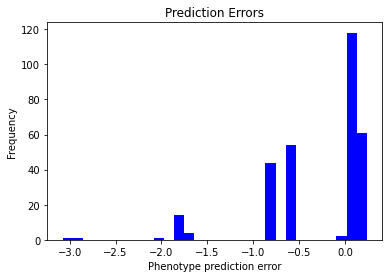

In [174]:
y_predict = model.predict(x_test)
y_predict = y_predict.reshape(len(y_predict))

diff = y_test - y_predict
plt.hist(diff,bins = 30, color = 'blue')
plt.title('Prediction Errors')
plt.xlabel('Phenotype prediction error')
plt.ylabel('Frequency')

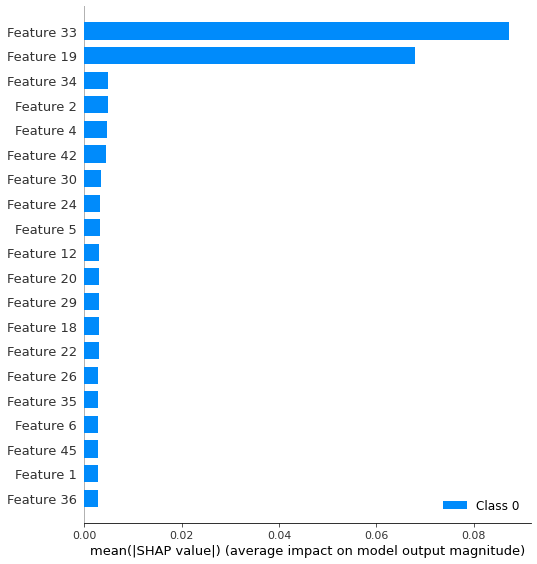

In [178]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

# Neural Network Compressed

In [ ]:
half =  round((loci_m-1)/2)
model = Sequential()
model.add(Dense(half, activation='relu', input_dim = loci_m-1))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu', input_dim = half))
model.add(Dropout(0.25))
model.compile(loss='mean_absolute_error', optimizer='rmsprop')
model.fit(x_train, y_train, epochs=50, batch_size=16, verbose = 0)
model.summary()

In [ ]:
half =  round((loci_m-1)/2)
model = Sequential()
model.add(Dense(half, activation='relu', input_dim = loci_m-1))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid', input_dim = half))
model.add(Dropout(0.25))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=50, batch_size=16, verbose = 0)
model.summary()

In [ ]:
y_predict = model.predict(x_test)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

In [ ]:
print('NN Accuracy: ', test_acc)

In [ ]:
#Evaluate the regression model
print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2))
print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
rmse = metrics.mean_squared_error(y_test, y_predict)
print("Root Mean squared error =", round(sqrt(rmse),2))
print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))

In [ ]:
y_predict = model.predict(x_test)
y_predict = y_predict.reshape(len(y_predict))

diff = y_test - y_predict
plt.hist(diff,bins = 30, color = 'blue')
plt.title('Prediction Errors')
plt.xlabel('Phenotype prediction error')
plt.ylabel('Frequency')

In [ ]:
warnings.filterwarnings("ignore")
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [ ]:
#need to inout training data, and number of features(loci) you are using
def NN_Expanded_SHAP(x_train,y_train,loci_m):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim = loci_m-1))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu', input_dim = 32))
    model.add(Dropout(0.25))
    model.compile(loss='mean_absolute_error', optimizer='rmsprop')
    model.fit(x_train, y_train, epochs=50, batch_size=16, verbose = 0)
    warnings.filterwarnings("ignore")
    explainer = shap.KernelExplainer(model.predict, shap.sample(x_train,50))
    shap_values = explainer.shap_values(x_train)
    return shap_values

In [ ]:
def NN_Compressed_SHAP(x_train,y_train,loci_m):
    half =  round((loci_m-1)/2)
    model = Sequential()
    model.add(Dense(half, activation='relu', input_dim = loci_m-1))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu', input_dim = half))
    model.add(Dropout(0.25))
    model.compile(loss='mean_absolute_error', optimizer='rmsprop')
    model.fit(x_train, y_train, epochs=50, batch_size=16, verbose = 0)
    warnings.filterwarnings("ignore")
    explainer = shap.KernelExplainer(model.predict, shap.sample(x_train,50))
    shap_values = explainer.shap_values(x_train)
    return shap_values

In [ ]:
shap_vals = NN_Expanded_SHAP(x_train,y_train,10)

In [ ]:
shap.summary_plot(shap_vals, x_train, plot_type="bar")